# Модель предсказывающая оценку по отзыву

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import torch
from torch import nn
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr

# Устанавливаем сид для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

df = pd.read_csv('cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1  # Классы от 0 до 4

def preprocess_text(text):
    return text.lower().strip() if isinstance(text, str) else ''

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df.dropna(subset=['processed_text', 'rating_class'])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text', 'combined_text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text', 'combined_text'])

tokenized_train = tokenized_train.rename_column("rating_class", "labels")
tokenized_test = tokenized_test.rename_column("rating_class", "labels")

num_labels = df['rating_class'].nunique()

class ClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        
        return (loss, logits) if loss is not None else logits

model = ClassificationModel('cointegrated/rubert-tiny', num_labels)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    spearman_corr, _ = spearmanr(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "spearman": spearman_corr
    }

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=2,
    fp16=True if torch.cuda.is_available() else False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Результаты оценки:", eval_results)

trainer.save_model("./final_model")

predictions = trainer.predict(tokenized_test).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = tokenized_test['labels']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 (weighted): {eval_results['eval_f1']:.4f}") 
print(f"Precision (weighted): {eval_results['eval_precision']:.4f}")
print(f"Recall (weighted): {eval_results['eval_recall']:.4f}")
print(f"Spearman correlation: {eval_results['eval_spearman']:.4f}")

# Дополнительная визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=num_labels, kde=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

Используется устройство: cpu


FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_kaspi_reviews.csv'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
import pymorphy2
import re

import os
os.environ["WANDB_DISABLED"] = "true"

# Устанавливаем сид для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1  # Классы от 0 до 4

# Инициализация анализатора pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Список стоп-слов (можно расширить при необходимости)
stop_words = [
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так',
    'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было',
    'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг',
    'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж',
    'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть',
    'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего',
    'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого',
    'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас',
    'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть',
    'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве',
    'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть', 'том',
    'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'
]

def preprocess_text(text):
    if pd.isna(text):
        return ''
    if not isinstance(text, str):
        text = str(text)
    
    # Приведение к нижнему регистру и удаление лишних пробелов
    text = text.lower().strip()
    
    # Удаление специальных символов и цифр
    text = re.sub(r'[^а-яёa-z\s]', '', text)
    
    # Лемматизация
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    
    # Удаление стоп-слов
    filtered_words = [word for word in lemmatized_words if word not in stop_words]
    
    return ' '.join(filtered_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']]
df = df.dropna()

tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/ruRoBERTa-large')

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=512)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    spearman_corr, _ = spearmanr(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "spearman": spearman_corr  
    }

def objective(trial, train_dataset, val_dataset):
    # Подбор гиперпараметров
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-4)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 1000)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [4, 8, 16])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])

    model = AutoModelForSequenceClassification.from_pretrained('sberbank-ai/ruRoBERTa-large', num_labels=5)

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=5,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    return eval_results["eval_f1"]

# Кросс-валидация
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

final_predictions = []
all_actual_classes = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df, df['rating_class']), 1):
    print(f"Fold {fold}")
    
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])
    tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])

    tokenized_train = tokenized_train.rename_column("rating_class", "labels")
    tokenized_val = tokenized_val.rename_column("rating_class", "labels")

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, tokenized_train, tokenized_val), n_trials=20)

    print(f"Fold {fold} - Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Обучение модели с лучшими параметрами
    best_model = AutoModelForSequenceClassification.from_pretrained('sberbank-ai/ruRoBERTa-large', num_labels=5)
    
    best_training_args = TrainingArguments(
        output_dir=f"./results/fold{fold}",
        num_train_epochs=10,
        per_device_train_batch_size=trial.params['per_device_train_batch_size'],
        per_device_eval_batch_size=16,
        learning_rate=trial.params['lr'],
        weight_decay=trial.params['weight_decay'],
        warmup_steps=trial.params['warmup_steps'],
        logging_dir=f'./logs/fold{fold}',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
        fp16=True,
    )

    best_trainer = Trainer(
        model=best_model,
        args=best_training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics
    )

    best_trainer.train()

    eval_results = best_trainer.evaluate()
    print(f"Fold {fold} Evaluation Results:")
    print(eval_results)
    
    best_trainer.save_model(f"./final_model/fold{fold}")

    # Предсказания для текущего фолда
    predictions = best_trainer.predict(tokenized_val).predictions
    final_predictions.append(predictions)
    all_actual_classes.extend(val_df['rating_class'])

print("Training completed. Models saved in ./final_model/ directory")

# Усреднение предсказаний моделей
final_predictions = np.mean(final_predictions, axis=0)
predicted_classes = np.argmax(final_predictions, axis=1)
actual_classes = np.array(all_actual_classes)

# Матрица ошибок
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

# Метрики 
acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}") 
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

# Дополнительная визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
from optuna.samplers import TPESampler
import pymorphy2
import re
from functools import partial, lru_cache
import gc

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1

morph = pymorphy2.MorphAnalyzer()
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

@lru_cache(maxsize=None)
def lemmatize(word):
    return morph.parse(word)[0].normal_form

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']].dropna()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

del df
gc.collect()

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256, use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], truncation=True, max_length=256)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'), 
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 500)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [32, 64, 128])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay, 
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="no", 
        metric_for_best_model="f1",
        greater_is_better=True, 
        load_best_model_at_end=False,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=4,
        optim="adamw_torch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset, 
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
    return eval_results["eval_f1"]

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

del train_df, val_df
gc.collect()

encoded_train = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])
encoded_val = val_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])

encoded_train = encoded_train.rename_column("rating_class", "labels")
encoded_val = encoded_val.rename_column("rating_class", "labels")

study = optuna.create_study(direction="maximize", sampler=TPESampler())
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=3)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

del study
gc.collect()
torch.cuda.empty_cache()

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",  
    num_train_epochs=5,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'], 
    per_device_eval_batch_size=64,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_steps=trial.params['warmup_steps'],
    logging_dir=f'./logs/best_model',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
    fp16=True, 
    dataloader_num_workers=4,
    optim="adamw_torch"
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = encoded_val['labels']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)  
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

del best_model, best_trainer
torch.cuda.empty_cache()  
gc.collect()

Используется устройство: cuda
GPU: Tesla P100-PCIE-16GB, Общая память: 17.06 GB
Общая память GPU: 16.79 GB
Свободная память GPU: 17.06 GB


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/89639 [00:00<?, ? examples/s]

Map:   0%|          | 0/22410 [00:00<?, ? examples/s]

[I 2024-07-13 10:11:34,127] A new study created in memory with name: no-name-0078b2db-d9be-44d0-aea0-e4a7c0686614


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be rem

Step,Training Loss,Validation Loss


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
import pymorphy2
import re

import os
os.environ["WANDB_DISABLED"] = "true"

# Устанавливаем сид для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

# Проверка доступной памяти GPU
if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    print(f"Доступная память: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1  # Классы от 0 до 4

# Инициализация анализатора pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Список стоп-слов (оставляем как есть)
stop_words = [
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так',
    # ... (остальные стоп-слова)
]

def preprocess_text(text):
    if pd.isna(text):
        return ''
    if not isinstance(text, str):
        text = str(text)
    
    # Приведение к нижнему регистру и удаление лишних пробелов
    text = text.lower().strip()
    
    # Удаление специальных символов и цифр
    text = re.sub(r'[^а-яёa-z\s]', '', text)
    
    # Лемматизация
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    
    # Удаление стоп-слов
    filtered_words = [word for word in lemmatized_words if word not in stop_words]
    
    return ' '.join(filtered_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']]
df = df.dropna()

# Используем модель DeepPavlov/rubert-base-cased
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=256)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    spearman_corr, _ = spearmanr(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "spearman": spearman_corr  
    }

def objective(trial, train_dataset, val_dataset):
    # Подбор гиперпараметров
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 1000)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [4, 8])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [4, 8])

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=8,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    return eval_results["eval_f1"]

# Кросс-валидация
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

final_predictions = []
all_actual_classes = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df, df['rating_class']), 1):
    print(f"Fold {fold}")
    
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])
    tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])

    tokenized_train = tokenized_train.rename_column("rating_class", "labels")
    tokenized_val = tokenized_val.rename_column("rating_class", "labels")

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, tokenized_train, tokenized_val), n_trials=20)

    print(f"Fold {fold} - Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Обучение модели с лучшими параметрами
    best_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
    
    best_training_args = TrainingArguments(
        output_dir=f"./results/fold{fold}",
        num_train_epochs=5,
        per_device_train_batch_size=trial.params['per_device_train_batch_size'],
        per_device_eval_batch_size=8,
        learning_rate=trial.params['lr'],
        weight_decay=trial.params['weight_decay'],
        warmup_steps=trial.params['warmup_steps'],
        logging_dir=f'./logs/fold{fold}',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
        fp16=True,
    )

    best_trainer = Trainer(
        model=best_model,
        args=best_training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics
    )

    best_trainer.train()

    eval_results = best_trainer.evaluate()
    print(f"Fold {fold} Evaluation Results:")
    print(eval_results)
    
    best_trainer.save_model(f"./final_model/fold{fold}")

    # Предсказания для текущего фолда
    predictions = best_trainer.predict(tokenized_val).predictions
    final_predictions.append(predictions)
    all_actual_classes.extend(val_df['rating_class'])

print("Training completed. Models saved in ./final_model/ directory")

# Усреднение предсказаний моделей
final_predictions = np.mean(final_predictions, axis=0)
predicted_classes = np.argmax(final_predictions, axis=1)
actual_classes = np.array(all_actual_classes)

# Матрица ошибок
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

# Метрики 
acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}") 
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

# Дополнительная визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

In [1]:
import gc

In [2]:
gc.collect()

11

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
import pymorphy2
import re
from functools import partial

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    print(f"Доступная память: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1

morph = pymorphy2.MorphAnalyzer()

stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words if word not in stop_words]
    return ' '.join(lemmatized_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']].dropna()

model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=128)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'),
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 500)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [2, 4])

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    return eval_results["eval_f1"]

n_splits = 3  # Уменьшаем количество фолдов
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

final_predictions = []
all_actual_classes = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df, df['rating_class']), 1):
    print(f"Fold {fold}")
    
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])
    tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])

    tokenized_train = tokenized_train.rename_column("rating_class", "labels")
    tokenized_val = tokenized_val.rename_column("rating_class", "labels")

    study = optuna.create_study(direction="maximize")
    objective_with_dataset = partial(objective, train_dataset=tokenized_train, val_dataset=tokenized_val)
    study.optimize(objective_with_dataset, n_trials=10)  # Уменьшаем количество trials

    print(f"Fold {fold} - Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    best_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
    
    best_training_args = TrainingArguments(
        output_dir=f"./results/fold{fold}",
        num_train_epochs=5,
        per_device_train_batch_size=trial.params['per_device_train_batch_size'],
        per_device_eval_batch_size=64,
        learning_rate=trial.params['lr'],
        weight_decay=trial.params['weight_decay'],
        warmup_steps=trial.params['warmup_steps'],
        logging_dir=f'./logs/fold{fold}',
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
        fp16=True,
    )

    best_trainer = Trainer(
        model=best_model,
        args=best_training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics
    )

    best_trainer.train()

    eval_results = best_trainer.evaluate()
    print(f"Fold {fold} Evaluation Results:")
    print(eval_results)
    
    best_trainer.save_model(f"./final_model/fold{fold}")

    predictions = best_trainer.predict(tokenized_val).predictions
    final_predictions.append(predictions)
    all_actual_classes.extend(val_df['rating_class'])

print("Training completed. Models saved in ./final_model/ directory")

final_predictions = np.mean(final_predictions, axis=0)
predicted_classes = np.argmax(final_predictions, axis=1)
actual_classes = np.array(all_actual_classes)

# Матрица ошибок
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

# Метрики 
acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}") 
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

# Дополнительная визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AdamW
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna


2024-07-12 20:24:41.748966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 20:24:41.749073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 20:24:41.903000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
import pymorphy2
import re
from functools import partial
import gc

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1

morph = pymorphy2.MorphAnalyzer()
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    lemmatized_words = (morph.parse(word)[0].normal_form for word in text.split() if word not in stop_words)
    return ' '.join(lemmatized_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']].dropna()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

del df
gc.collect()

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256)

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], truncation=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'), 
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 500)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32, 64])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [4, 8, 16])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay, 
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="no", 
        metric_for_best_model="f1",
        greater_is_better=True, 
        load_best_model_at_end=False,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=4,
        optim="adafactor"  
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset, 
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
    return eval_results["eval_f1"]

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

del train_df, val_df
gc.collect()

encoded_train = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])
encoded_val = val_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])

encoded_train = encoded_train.rename_column("rating_class", "labels")
encoded_val = encoded_val.rename_column("rating_class", "labels")

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=3)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

del study
gc.collect()
torch.cuda.empty_cache()

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",  
    num_train_epochs=5,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'], 
    per_device_eval_batch_size=64,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_steps=trial.params['warmup_steps'],
    logging_dir=f'./logs/best_model',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
    fp16=True, 
    dataloader_num_workers=4,
    optim="adafactor"
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = encoded_val['labels']

# Матрица ошибок
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

# Метрики
acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

# Дополнительная визуализация 
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)  
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

del best_model, best_trainer
torch.cuda.empty_cache()  
gc.collect()

In [5]:
import pymorphy2
import re
from functools import partial

In [2]:
import gc

In [3]:
gc.collect()

11

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
from optuna.samplers import TPESampler
import pymorphy2
import re
from functools import partial, lru_cache
import gc

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1

morph = pymorphy2.MorphAnalyzer()
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

@lru_cache(maxsize=None)
def lemmatize(word):
    return morph.parse(word)[0].normal_form

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']].dropna()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

del df
gc.collect()

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256, use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], truncation=True, max_length=256)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'), 
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 500)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [32, 64, 128])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay, 
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="no", 
        metric_for_best_model="f1",
        greater_is_better=True, 
        load_best_model_at_end=False,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=4,
        optim="adamw_torch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset, 
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
    return eval_results["eval_f1"]

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

del train_df, val_df
gc.collect()

encoded_train = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])
encoded_val = val_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])

encoded_train = encoded_train.rename_column("rating_class", "labels")
encoded_val = encoded_val.rename_column("rating_class", "labels")

study = optuna.create_study(direction="maximize", sampler=TPESampler())
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=3)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

del study
gc.collect()
torch.cuda.empty_cache()

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",  
    num_train_epochs=5,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'], 
    per_device_eval_batch_size=64,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_steps=trial.params['warmup_steps'],
    logging_dir=f'./logs/best_model',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
    fp16=True, 
    dataloader_num_workers=4,
    optim="adamw_torch"
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = encoded_val['labels']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)  
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

del best_model, best_trainer
torch.cuda.empty_cache()  
gc.collect()

In [6]:


import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1

morph = pymorphy2.MorphAnalyzer()
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    lemmatized_words = [morph.parse(word)[0].normal_form for word in text.split() if word not in stop_words]
    return ' '.join(lemmatized_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']].dropna()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

# Используем стандартный токенизатор из transformers
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=128)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'), 
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 500)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [32, 64])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [2, 4])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=128,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="epoch", 
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args, 
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    return eval_results["eval_f1"]

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

encoded_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])
encoded_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text'])

encoded_train.set_format(type="torch", columns=['input_ids', 'attention_mask', 'rating_class'])
encoded_val.set_format(type="torch", columns=['input_ids', 'attention_mask', 'rating_class'])

encoded_train = encoded_train.rename_column("rating_class", "labels")
encoded_val = encoded_val.rename_column("rating_class", "labels")

study = optuna.create_study(direction="maximize")
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=5)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",  
    num_train_epochs=5,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'], 
    per_device_eval_batch_size=128,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_steps=trial.params['warmup_steps'],
    logging_dir=f'./logs/best_model',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, 
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'], 
    fp16=True,
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = val_df['rating_class']

# Визуализация и метрики (оставляем без изменений)
# ...

# Матрица ошибок
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

# Метрики
acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

# Дополнительная визуализация 
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)  
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

Используется устройство: cuda
GPU: Tesla P100-PCIE-16GB, Общая память: 17.06 GB
Общая память GPU: 16.79 GB
Свободная память GPU: 17.06 GB


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/89639 [00:00<?, ? examples/s]

Map:   0%|          | 0/22410 [00:00<?, ? examples/s]

[I 2024-07-12 20:31:41,868] A new study created in memory with name: no-name-c6354f65-a6d2-47dc-9015-f8d5a751b11f


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be rem

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
0,0.440700,0.427637,0.855288,0.802617,0.802198,0.855288,0.442637


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[W 2024-07-12 20:50:25,650] Trial 0 failed with parameters: {'lr': 1.629174368249374e-05, 'weight_decay': 0.00012897438760911791, 'warmup_steps': 173, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_35/4289091445.py", line 92, in objective
    trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/transformers/trainer.py", line 1932, in train
    return inner_training_loop(
  File "/opt/conda/lib/python3.10/site-packages/t

KeyboardInterrupt: 

In [4]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [2]:
import pandas as pd

In [1]:
print(f"Accuracy: {acc:.4f}")

NameError: name 'acc' is not defined

2024-07-12 21:15:30.369234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 21:15:30.369344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 21:15:30.495830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Используется устройство: cuda
GPU: Tesla P100-PCIE-16GB, Общая память: 17.06 GB
Общая память GPU: 16.79 GB
Свободная память GPU: 17.06 GB


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/89639 [00:00<?, ? examples/s]

Map:   0%|          | 0/22410 [00:00<?, ? examples/s]

[I 2024-07-12 21:21:36,219] A new study created in memory with name: no-name-90add2d3-c025-42c5-9b35-c313bc53a0fe


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be rem

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
0,0.468300,0.436497,0.853458,0.799995,0.786820,0.853458,0.400768
1,0.415900,0.406833,0.862115,0.836004,0.821805,0.862115,0.548216
2,0.386700,0.402884,0.863498,0.835314,0.823301,0.863498,0.548569


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-12 22:05:42,314] Trial 0 finished with value: 0.8353135114785433 and parameters: {'lr': 1.5908689043323806e-05, 'weight_decay': 0.0005547721817754297, 'warmup_steps': 387, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 16}. Best is trial 0 with value: 0.8353135114785433.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in versio

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
0,0.439400,0.403840,0.862561,0.830476,0.818269,0.862561,0.515236
1,0.382900,0.395511,0.864480,0.845506,0.840182,0.864480,0.578726
2,0.310500,0.408704,0.862829,0.846218,0.836953,0.862829,0.586902


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-12 22:52:51,305] Trial 1 finished with value: 0.8462179470344828 and parameters: {'lr': 2.6687655611407676e-05, 'weight_decay': 0.00010165203968063754, 'warmup_steps': 168, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 4}. Best is trial 1 with value: 0.8462179470344828.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in versio

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
0,0.481900,0.460531,0.849041,0.784844,0.785110,0.849041,0.224224
1,0.425100,0.409776,0.860107,0.837775,0.825257,0.860107,0.563943
2,0.377700,0.397582,0.864257,0.840269,0.832418,0.864257,0.568114


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-12 23:53:40,635] Trial 2 finished with value: 0.8402689777374475 and parameters: {'lr': 5.310870371040237e-05, 'weight_decay': 0.001937599363616159, 'warmup_steps': 261, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 8}. Best is trial 1 with value: 0.8462179470344828.


Best trial:
  Value:  0.8462179470344828
  Params: 
    lr: 2.6687655611407676e-05
    weight_decay: 0.00010165203968063754
    warmup_steps: 168
    per_device_train_batch_size: 16
    gradient_accumulation_steps: 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The curr

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
0,0.443300,0.404488,0.863320,0.829794,0.818031,0.863320,0.512466
1,0.388700,0.397359,0.862874,0.844235,0.832823,0.862874,0.576126
2,0.321400,0.408967,0.859349,0.845811,0.841690,0.859349,0.587751
4,0.252400,0.473034,0.855689,0.846079,0.838661,0.855689,0.584375


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Final Evaluation Results:
{'eval_loss': 0.4423908293247223, 'eval_accuracy': 0.8592592592592593, 'eval_f1': 0.8473316495318277, 'eval_precision': 0.8390448072429096, 'eval_recall': 0.8592592592592593, 'eval_spearman': 0.588081419589789, 'eval_runtime': 89.3509, 'eval_samples_per_second': 250.809, 'eval_steps_per_second': 3.928, 'epoch': 4.997322862752097}
Training completed. Model saved in ./final_model/ directory


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

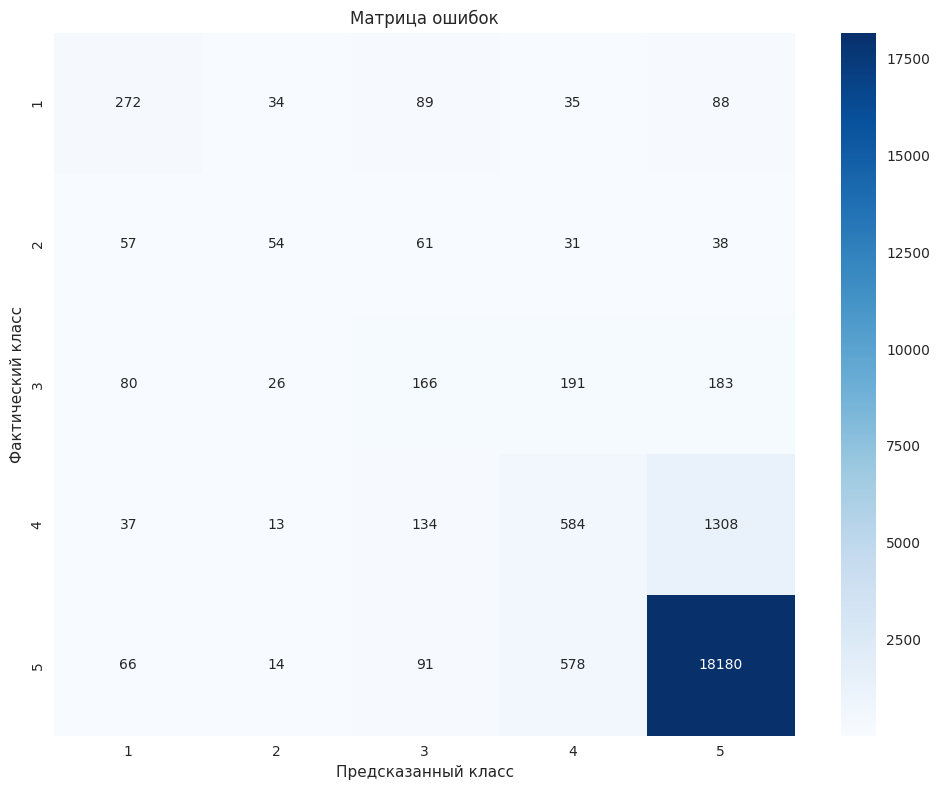

Accuracy: 0.8593
F1 (weighted): 0.8473
Precision (weighted): 0.8390
Recall (weighted): 0.8593
Spearman correlation: 0.5881


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


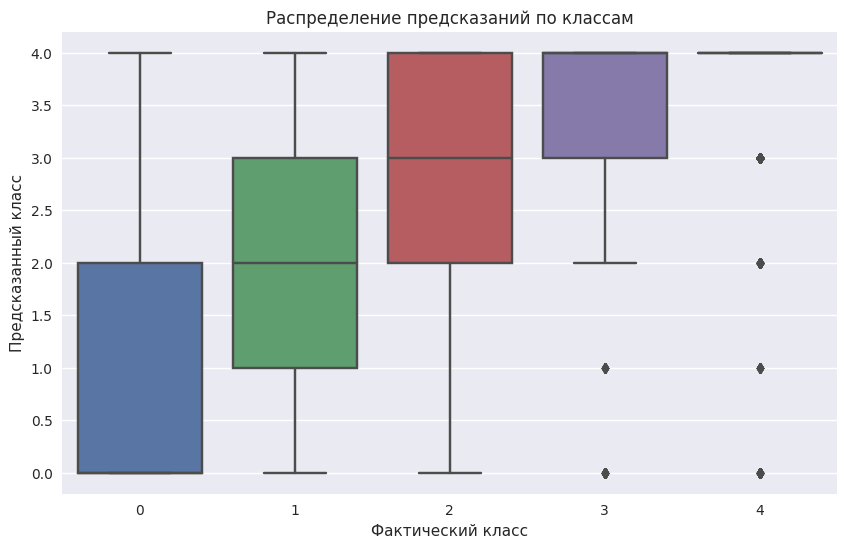

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


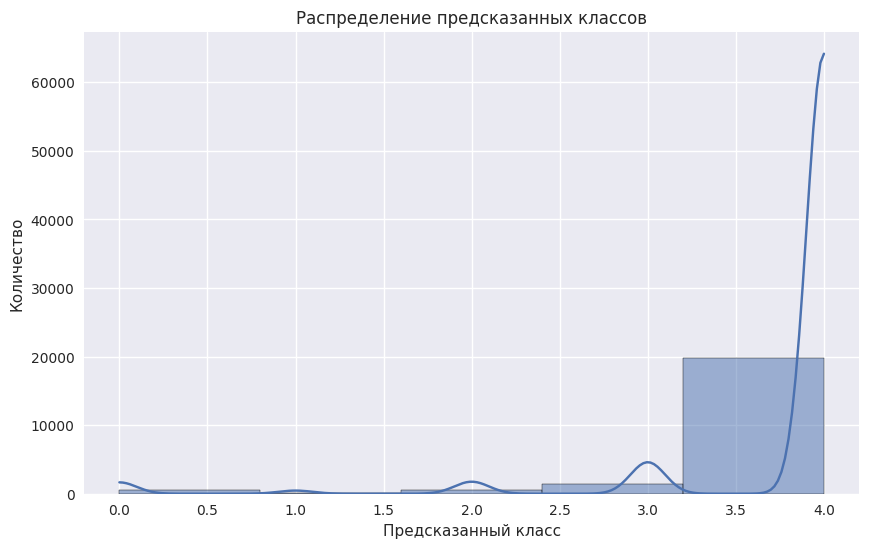

12059

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
import pymorphy2
import re
from functools import partial
import gc

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1

morph = pymorphy2.MorphAnalyzer()
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    lemmatized_words = (morph.parse(word)[0].normal_form for word in text.split() if word not in stop_words)
    return ' '.join(lemmatized_words)

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df[['processed_text', 'rating_class']].dropna()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

del df
gc.collect()

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256)

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], truncation=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'), 
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 500)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32, 64])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [4, 8, 16])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay, 
        warmup_steps=warmup_steps,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="no", 
        metric_for_best_model="f1",
        greater_is_better=True, 
        load_best_model_at_end=False,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=4,
        optim="adafactor"  
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset, 
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
    return eval_results["eval_f1"]

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

del train_df, val_df
gc.collect()

encoded_train = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])
encoded_val = val_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])

encoded_train = encoded_train.rename_column("rating_class", "labels")
encoded_val = encoded_val.rename_column("rating_class", "labels")

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=3)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

del study
gc.collect()
torch.cuda.empty_cache()

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5, use_cache=False).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",  
    num_train_epochs=5,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'], 
    per_device_eval_batch_size=64,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_steps=trial.params['warmup_steps'],
    logging_dir=f'./logs/best_model',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
    fp16=True, 
    dataloader_num_workers=4,
    optim="adafactor"
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = encoded_val['labels']

# Матрица ошибок
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

# Метрики
acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

# Дополнительная визуализация 
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)  
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

del best_model, best_trainer
torch.cuda.empty_cache()  
gc.collect()

In [3]:
# Функция для предсказания оценок для новых отзывов
def predict_ratings(reviews):
    if len(reviews) == 0:
        return []
    
    # Создаем DataFrame из новых отзывов
    new_data = pd.DataFrame({'combined_text': reviews})
    new_data['processed_text'] = new_data['combined_text'].apply(preprocess_text)
    new_dataset = Dataset.from_pandas(new_data)
    
    # Токенизируем новые отзывы
    tokenized_new_data = new_dataset.map(tokenize_function, batched=True, remove_columns=['combined_text'])
    
    # Получаем предсказания модели для новых отзывов
    predictions = trainer.predict(tokenized_new_data).predictions
    
    if len(predictions.shape) == 1:
        predicted_ratings = np.argmax(predictions.reshape(1, -1), axis=1) + 1
    else:
        predicted_ratings = np.argmax(predictions, axis=1) + 1
    
    return predicted_ratings.tolist()

# Функция для ввода отзывов с клавиатуры
def input_reviews():
    reviews = []
    while True:
        review = input("Введите отзыв (или нажмите Enter для завершения): ")
        if review == "":
            break
        reviews.append(review)
    return reviews

# Вызываем функцию для ввода отзывов с клавиатуры
new_reviews = input_reviews()

# Получаем предсказанные оценки для введенных отзывов
predicted_ratings = predict_ratings(new_reviews)

# Выводим результаты предсказаний
if len(predicted_ratings) == 0:
    print("Нет введенных отзывов.")
else:
    for review, rating in zip(new_reviews, predicted_ratings):
        print(f"Отзыв: {review}")
        print(f"Предсказанная оценка: {rating}")
        print()

Введите отзыв (или нажмите Enter для завершения):  ыв
Введите отзыв (или нажмите Enter для завершения):  


NameError: name 'preprocess_text' is not defined

In [5]:
gc.collect()

NameError: name 'gc' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset, load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
from optuna.samplers import TPESampler
import pymorphy2
import re
from functools import partial, lru_cache
import gc
from transformers import get_linear_schedule_with_warmup

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

# Проверяем, есть ли уже обработанные данные
if os.path.exists('./processed_data'):
    encoded_train = load_from_disk('./processed_data/train')
    encoded_val = load_from_disk('./processed_data/val')
    print("Загружены предобработанные данные")
else:
    df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
    df = df[df['language'] == 'russian']
    df['rating_class'] = df['rating'].astype(int) - 1

    morph = pymorphy2.MorphAnalyzer()
    stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

    @lru_cache(maxsize=None)
    def lemmatize(word):
        return morph.parse(word)[0].normal_form

    def preprocess_text(text):
        if pd.isna(text) or not isinstance(text, str):
            return ''
        text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
        return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

    df['processed_text'] = df['combined_text'].apply(preprocess_text)
    df = df[['processed_text', 'rating_class']].dropna()

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

    del df
    gc.collect()

    tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=512, use_fast=True)

    def tokenize_function(examples):
        return tokenizer(examples["processed_text"], truncation=True, max_length=512)

    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

    del train_df, val_df
    gc.collect()

    encoded_train = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])
    encoded_val = val_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])

    encoded_train = encoded_train.rename_column("rating_class", "labels")
    encoded_val = encoded_val.rename_column("rating_class", "labels")

    # Сохраняем обработанные данные
    encoded_train.save_to_disk('./processed_data/train')
    encoded_val.save_to_disk('./processed_data/val')
    print("Данные обработаны и сохранены")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'), 
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    warmup_ratio = trial.suggest_float('warmup_ratio', 0.1, 0.3)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [2, 4, 8])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=5,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay, 
        warmup_ratio=warmup_ratio,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="no", 
        metric_for_best_model="f1",
        greater_is_better=True, 
        load_best_model_at_end=False,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=4,
        optim="adamw_torch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset, 
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
    return eval_results["eval_f1"]

study = optuna.create_study(direction="maximize", sampler=TPESampler())
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

del study
gc.collect()
torch.cuda.empty_cache()

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",  
    num_train_epochs=10,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'], 
    per_device_eval_batch_size=64,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_ratio=trial.params['warmup_ratio'],
    logging_dir=f'./logs/best_model',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
    fp16=True, 
    dataloader_num_workers=4,
    optim="adamw_torch"
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = encoded_val['labels']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)  
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

del best_model, best_trainer
torch.cuda.empty_cache()  
gc.collect()

Используется устройство: cuda
GPU: Tesla P100-PCIE-16GB, Общая память: 17.06 GB
Общая память GPU: 16.79 GB
Свободная память GPU: 17.06 GB


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/89639 [00:00<?, ? examples/s]

Map:   0%|          | 0/22410 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/89639 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22410 [00:00<?, ? examples/s]

[I 2024-07-13 10:31:53,845] A new study created in memory with name: no-name-264cfe5b-dba0-465f-9b9d-8b6315bc84b4


Данные обработаны и сохранены


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be rem

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.554500,0.508857,0.844578,0.778092,0.735286,0.844578,0.167706
1000,0.478000,0.455125,0.850201,0.807494,0.789651,0.850201,0.446652
1500,0.421500,0.444806,0.851539,0.803628,0.802166,0.851539,0.465818
2000,0.450300,0.431311,0.855556,0.810837,0.799206,0.855556,0.466756
2500,0.429600,0.417817,0.859349,0.825739,0.809636,0.859349,0.506089
3000,0.390900,0.428604,0.857385,0.811276,0.802438,0.857385,0.474174
3500,0.430600,0.414507,0.859393,0.827536,0.817012,0.859393,0.533089
4000,0.419000,0.420860,0.859393,0.822049,0.811150,0.859393,0.517477
4500,0.427500,0.411024,0.859750,0.830580,0.813846,0.859750,0.526442
5000,0.449300,0.407155,0.860464,0.829218,0.820845,0.860464,0.553536


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [2]:
!pip install pymorphy2

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.5 MB/s eta 0:00:00:00:0100:01


In [3]:
import gc
gc.collect()

11

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import torch
from torch import nn
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr

import os
os.environ["WANDB_DISABLED"] = "true"

# Устанавливаем сид для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_class'] = df['rating'].astype(int) - 1  # Классы от 0 до 4

def preprocess_text(text):
    return text.lower().strip() if isinstance(text, str) else ''

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df.dropna(subset=['processed_text', 'rating_class'])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text', 'combined_text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text', 'combined_text'])

tokenized_train = tokenized_train.rename_column("rating_class", "labels")
tokenized_test = tokenized_test.rename_column("rating_class", "labels")

num_labels = df['rating_class'].nunique()

class ClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        
        return (loss, logits) if loss is not None else logits

model = ClassificationModel('cointegrated/rubert-tiny', num_labels)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    spearman_corr, _ = spearmanr(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "spearman": spearman_corr
    }

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=2,
    fp16=True if torch.cuda.is_available() else False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Результаты оценки:", eval_results)

trainer.save_model("./final_model")

predictions = trainer.predict(tokenized_test).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = tokenized_test['labels']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 (weighted): {eval_results['eval_f1']:.4f}") 
print(f"Precision (weighted): {eval_results['eval_precision']:.4f}")
print(f"Recall (weighted): {eval_results['eval_recall']:.4f}")
print(f"Spearman correlation: {eval_results['eval_spearman']:.4f}")

# Дополнительная визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

# Распределение предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=num_labels, kde=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset, load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
from optuna.samplers import TPESampler
import pymorphy2
import re
from functools import partial, lru_cache
import gc

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

# Проверяем, есть ли уже обработанные данные
if os.path.exists('./processed_data'):
    encoded_train = load_from_disk('./processed_data/train')
    encoded_val = load_from_disk('./processed_data/val')
    print("Загружены предобработанные данные")
else:
    df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
    df = df[df['language'] == 'russian']
    df['rating_class'] = df['rating'].astype(int) - 1

    morph = pymorphy2.MorphAnalyzer()
    stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

    @lru_cache(maxsize=None)
    def lemmatize(word):
        return morph.parse(word)[0].normal_form

    def preprocess_text(text):
        if pd.isna(text) or not isinstance(text, str):
            return ''
        text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
        return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

    df['processed_text'] = df['combined_text'].apply(preprocess_text)
    df = df[['processed_text', 'rating_class']].dropna()

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

    del df
    gc.collect()

    tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256, use_fast=True)

    def tokenize_function(examples):
        return tokenizer(examples["processed_text"], truncation=True, max_length=256)

    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

    del train_df, val_df
    gc.collect()

    encoded_train = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])
    encoded_val = val_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])

    encoded_train = encoded_train.rename_column("rating_class", "labels")
    encoded_val = encoded_val.rename_column("rating_class", "labels")

    # Сохраняем закодированные наборы данных на диск
    encoded_train.save_to_disk('./processed_data/train')
    encoded_val.save_to_disk('./processed_data/val')
    print("Данные обработаны и сохранены")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'),
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-1, log=True)
    warmup_ratio = trial.suggest_float('warmup_ratio', 0.1, 0.3)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [32, 64])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="no",
        metric_for_best_model="f1",
        greater_is_better=True,
        load_best_model_at_end=False,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=6,
        optim="adamw_torch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
    return eval_results["eval_f1"]

study = optuna.create_study(direction="maximize", sampler=TPESampler())
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

del study
gc.collect()
torch.cuda.empty_cache()

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",
    num_train_epochs=5,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'],
    per_device_eval_batch_size=64,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_ratio=trial.params['warmup_ratio'],
    logging_dir=f'./logs/best_model',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
    fp16=True,
    dataloader_num_workers=6,
    optim="adamw_torch"
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = encoded_val['labels']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

del best_model, best_trainer
torch.cuda.empty_cache()
gc.collect()

Используется устройство: cuda
GPU: Tesla P100-PCIE-16GB, Общая память: 17.06 GB
Общая память GPU: 16.79 GB
Свободная память GPU: 17.06 GB


Map:   0%|          | 0/89639 [00:00<?, ? examples/s]

Map:   0%|          | 0/22410 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/89639 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22410 [00:00<?, ? examples/s]

[I 2024-07-13 13:44:05,516] A new study created in memory with name: no-name-9c7103e6-b953-4aa6-834a-14e3c5b8238f


Данные обработаны и сохранены


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be rem

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.549100,0.513470,0.844578,0.776738,0.732959,0.844578,0.143102
1000,0.479200,0.454114,0.851049,0.799976,0.770562,0.851049,0.374745
1500,0.421900,0.446886,0.851406,0.806747,0.813945,0.851406,0.476772
2000,0.445400,0.427374,0.855913,0.808510,0.797749,0.855913,0.451610
2500,0.425100,0.416201,0.860241,0.832242,0.818206,0.860241,0.534618
3000,0.388000,0.418405,0.862115,0.831430,0.822711,0.862115,0.518005
3500,0.423100,0.406698,0.861446,0.834909,0.824812,0.861446,0.560370
4000,0.401800,0.407659,0.861580,0.833453,0.820418,0.861580,0.556473
4500,0.401400,0.406532,0.857564,0.843366,0.831485,0.857564,0.586494
5000,0.432600,0.399940,0.865105,0.838377,0.827151,0.865105,0.555853


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 14:57:49,874] Trial 0 finished with value: 0.8449373972480296 and parameters: {'lr': 1.2908549889168956e-05, 'weight_decay': 0.005103235594127304, 'warmup_ratio': 0.20031204046361972, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 1}. Best is trial 0 with value: 0.8449373972480296.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be rem

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.458700,0.457488,0.848907,0.786391,0.766977,0.848907,0.267915
1000,0.451600,0.424410,0.857073,0.826741,0.813072,0.857073,0.516674
1500,0.405500,0.414798,0.856894,0.837705,0.824476,0.856894,0.549954
2000,0.395500,0.407590,0.857787,0.835000,0.822641,0.857787,0.566061
2500,0.409300,0.397742,0.864212,0.838941,0.829430,0.864212,0.553894
3000,0.346800,0.405058,0.860509,0.846863,0.837640,0.860509,0.591649
3500,0.350900,0.404855,0.864480,0.843685,0.833770,0.864480,0.578305
4000,0.349900,0.400785,0.863498,0.844011,0.835188,0.863498,0.582050


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 16:07:54,053] Trial 1 finished with value: 0.8452050854315599 and parameters: {'lr': 1.8113121559653823e-05, 'weight_decay': 0.0016944490683774038, 'warmup_ratio': 0.17469543112886446, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 1}. Best is trial 1 with value: 0.8452050854315599.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be re

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.437200,0.429138,0.855422,0.820127,0.810937,0.855422,0.514251
1000,0.403300,0.416942,0.854975,0.828642,0.820820,0.854975,0.561888
1500,0.332800,0.408509,0.858322,0.846569,0.838387,0.858322,0.588779
2000,0.344400,0.402647,0.862695,0.845243,0.836685,0.862695,0.587676


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 17:10:45,788] Trial 2 finished with value: 0.846695782810575 and parameters: {'lr': 4.21914509537095e-05, 'weight_decay': 0.009384607119192066, 'warmup_ratio': 0.2793705261401517, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 2}. Best is trial 2 with value: 0.846695782810575.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.488100,0.478244,0.845649,0.782522,0.740846,0.845649,0.245852
1000,0.465300,0.434199,0.855020,0.822886,0.807591,0.855020,0.506422
1500,0.419700,0.423430,0.856939,0.829464,0.816218,0.856939,0.506961
2000,0.405900,0.412992,0.857385,0.833413,0.820499,0.857385,0.557531
2500,0.420300,0.404243,0.863231,0.831326,0.816522,0.863231,0.529535
3000,0.366600,0.404947,0.861312,0.843602,0.835607,0.861312,0.579797
3500,0.371000,0.406148,0.863498,0.839515,0.829936,0.863498,0.565254
4000,0.368100,0.401107,0.863454,0.840052,0.829223,0.863454,0.573669


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 18:20:41,670] Trial 3 finished with value: 0.840466066878496 and parameters: {'lr': 1.0575488202143836e-05, 'weight_decay': 0.004587317825934914, 'warmup_ratio': 0.2357886622799123, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 1}. Best is trial 2 with value: 0.846695782810575.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be remove

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.504300,0.489455,0.849264,0.786121,0.743520,0.849264,0.244277
1000,0.466000,0.446358,0.854172,0.797076,0.778382,0.854172,0.376166
1500,0.443400,0.455919,0.844712,0.799306,0.765619,0.844712,0.504532
2000,0.480400,0.446641,0.851495,0.792242,0.763195,0.851495,0.332607
2500,0.442500,0.453687,0.856983,0.826146,0.809185,0.856983,0.506147
3000,0.419000,0.446032,0.853101,0.801979,0.814351,0.853101,0.454453
3500,0.449100,0.457443,0.856582,0.832400,0.816678,0.856582,0.545300
4000,0.432600,0.444031,0.859527,0.815845,0.804596,0.859527,0.482341
4500,0.421800,0.440918,0.850602,0.833796,0.823935,0.850602,0.545837
5000,0.447300,0.430693,0.859259,0.836189,0.822976,0.859259,0.560887


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 19:33:59,322] Trial 4 finished with value: 0.841624913275903 and parameters: {'lr': 8.277445575479811e-05, 'weight_decay': 0.09296085054594586, 'warmup_ratio': 0.21481125312117733, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 1}. Best is trial 2 with value: 0.846695782810575.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.550200,0.513551,0.844668,0.773541,0.713463,0.844668,nan
1000,0.482800,0.466245,0.849487,0.794583,0.764157,0.849487,0.336728
1500,0.419700,0.441047,0.852209,0.810869,0.806179,0.852209,0.475091
2000,0.451100,0.432932,0.855600,0.812678,0.798658,0.855600,0.463824
2500,0.429900,0.425029,0.858724,0.823858,0.814200,0.858724,0.513370
3000,0.389400,0.420770,0.860598,0.830620,0.818238,0.860598,0.510251
3500,0.429500,0.410238,0.859750,0.826963,0.820555,0.859750,0.535946
4000,0.403800,0.407433,0.861000,0.828845,0.818094,0.861000,0.537667
4500,0.407600,0.405387,0.858858,0.841904,0.829439,0.858858,0.569454
5000,0.435900,0.401827,0.864079,0.836297,0.824805,0.864079,0.551092


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 20:47:17,956] Trial 5 finished with value: 0.8444547405419074 and parameters: {'lr': 1.1628440612281945e-05, 'weight_decay': 0.09399225385040957, 'warmup_ratio': 0.22360217043327646, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 1}. Best is trial 2 with value: 0.846695782810575.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be remov

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.448000,0.452833,0.852075,0.790266,0.760251,0.852075,0.330933
1000,0.465400,0.446676,0.851896,0.792598,0.754545,0.851896,0.349547
1500,0.421000,0.425358,0.856627,0.823692,0.809352,0.856627,0.495121
2000,0.412700,0.418232,0.859750,0.837370,0.823080,0.859750,0.565034
2500,0.413900,0.410266,0.862963,0.836380,0.821001,0.862963,0.549605
3000,0.340700,0.427696,0.859661,0.836174,0.823681,0.859661,0.569344
3500,0.343000,0.416908,0.864971,0.840546,0.829296,0.864971,0.569095
4000,0.332700,0.423378,0.859839,0.844904,0.836146,0.859839,0.584973


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 21:57:13,604] Trial 6 finished with value: 0.8449711487778618 and parameters: {'lr': 9.052400594277023e-05, 'weight_decay': 0.0015168796304120772, 'warmup_ratio': 0.19936912457688194, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 1}. Best is trial 2 with value: 0.846695782810575.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be remo

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.449600,0.451266,0.851049,0.796522,0.775784,0.851049,0.338741
1000,0.453500,0.429864,0.854752,0.799174,0.791663,0.854752,0.417902
1500,0.416100,0.422944,0.859170,0.821779,0.813291,0.859170,0.496056
2000,0.410200,0.435102,0.850067,0.834144,0.825839,0.850067,0.571445
2500,0.416800,0.405026,0.861892,0.834195,0.818182,0.861892,0.550739
3000,0.345100,0.418975,0.855957,0.843700,0.839331,0.855957,0.593497
3500,0.342500,0.409511,0.862784,0.838406,0.827959,0.862784,0.565121
4000,0.337300,0.409752,0.861624,0.844803,0.835703,0.861624,0.583874


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-13 23:07:10,704] Trial 7 finished with value: 0.8472489786057343 and parameters: {'lr': 6.595368363589886e-05, 'weight_decay': 0.004428752267862051, 'warmup_ratio': 0.28267504629895923, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 1}. Best is trial 7 with value: 0.8472489786057343.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be remo

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.467100,0.459218,0.847880,0.781363,0.732340,0.847880,0.175924
1000,0.457300,0.436856,0.854529,0.802031,0.782177,0.854529,0.446377
1500,0.413700,0.422977,0.858010,0.833608,0.819327,0.858010,0.531949
2000,0.407600,0.418664,0.855868,0.838632,0.825852,0.855868,0.574062
2500,0.413200,0.410789,0.863141,0.828449,0.813872,0.863141,0.525547
3000,0.336900,0.429644,0.847702,0.840123,0.833285,0.847702,0.580878
3500,0.339800,0.421776,0.861089,0.838137,0.827341,0.861089,0.566291
4000,0.327700,0.426641,0.858411,0.842524,0.835339,0.858411,0.574972


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-14 00:06:19,712] Trial 8 finished with value: 0.8413704791104608 and parameters: {'lr': 9.284592059747402e-05, 'weight_decay': 0.010106986253487358, 'warmup_ratio': 0.12441696281081911, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 2}. Best is trial 7 with value: 0.8472489786057343.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be remo

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.419700,0.414583,0.860062,0.835728,0.821073,0.860062,0.554697
1000,0.392900,0.405321,0.860732,0.833539,0.832534,0.860732,0.554410


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-07-14 01:05:36,541] Trial 9 finished with value: 0.8350537223997377 and parameters: {'lr': 1.3611049248706139e-05, 'weight_decay': 0.0068580610507093884, 'warmup_ratio': 0.1183149979230736, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 4}. Best is trial 7 with value: 0.8472489786057343.


Best trial:
  Value:  0.8472489786057343
  Params: 
    lr: 6.595368363589886e-05
    weight_decay: 0.004428752267862051
    warmup_ratio: 0.28267504629895923
    per_device_train_batch_size: 64
    gradient_accumulation_steps: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: steps
- Save strategy: epoch

2024-07-14 03:35:17.829177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 03:35:17.829372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 03:35:17.958531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Используется устройство: cuda
GPU: Tesla P100-PCIE-16GB, Общая память: 17.06 GB
Общая память GPU: 16.79 GB
Свободная память GPU: 17.06 GB


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/89639 [00:00<?, ? examples/s]

Map:   0%|          | 0/22410 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/89639 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22410 [00:00<?, ? examples/s]

[I 2024-07-14 03:35:55,454] A new study created in memory with name: no-name-7428978d-f6ae-4e29-99c6-141593eee4e2


Данные обработаны и сохранены


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be rem

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.404800,0.419694,0.856627,0.830801,0.824443,0.856627,0.549787
1000,0.342000,0.406166,0.863141,0.844933,0.835771,0.863141,0.586659


[I 2024-07-14 04:36:25,536] Trial 0 finished with value: 0.8470377699516728 and parameters: {'lr': 8.373000577537992e-05, 'weight_decay': 0.09133311151769442, 'warmup_ratio': 0.23770055385498493, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 4}. Best is trial 0 with value: 0.8470377699516728.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logg

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.412100,0.408677,0.861044,0.831446,0.816902,0.861044,0.534992
1000,0.372900,0.400262,0.862918,0.837787,0.826341,0.862918,0.568555


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2024-07-14 05:37:00,311] Trial 1 finished with value: 0.8405681839139436 and parameters: {'lr': 2.4630040082862688e-05, 'weight_decay': 0.0687607389556874, 'warmup_ratio': 0.24717400447156507, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 4}. Best is trial 0 with value: 0.8470377699516728.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logg

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.519600,0.493736,0.845114,0.776397,0.734690,0.845114,0.136588
1000,0.460700,0.444366,0.854261,0.802292,0.778606,0.854261,0.394692
1500,0.423900,0.450307,0.852075,0.811416,0.811460,0.852075,0.498615
2000,0.458300,0.433483,0.855065,0.795855,0.788600,0.855065,0.395184
2500,0.428100,0.442286,0.855779,0.828806,0.812529,0.855779,0.515889
3000,0.386000,0.416715,0.859393,0.820329,0.812961,0.859393,0.500301
3500,0.425500,0.423166,0.852164,0.831703,0.824424,0.852164,0.567447
4000,0.404800,0.409024,0.862160,0.828553,0.821619,0.862160,0.560393
4500,0.407200,0.424950,0.849576,0.840223,0.832963,0.849576,0.572231
5000,0.427700,0.413096,0.864212,0.831892,0.819244,0.864212,0.553932


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

[I 2024-07-14 06:52:38,186] Trial 2 finished with value: 0.8443133626381017 and parameters: {'lr': 4.175889942231109e-05, 'weight_decay': 0.02062955456547391, 'warmup_ratio': 0.24104171894041945, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 1}. Best is trial 0 with value: 0.8470377699516728.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logg

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.437900,0.442390,0.854797,0.804256,0.790514,0.854797,0.435750
1000,0.408900,0.413400,0.858367,0.827869,0.816876,0.858367,0.539125
1500,0.366800,0.405628,0.861446,0.842155,0.832185,0.861446,0.566971
2000,0.387600,0.403217,0.861758,0.835918,0.826036,0.861758,0.561065


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2024-07-14 07:56:49,943] Trial 3 finished with value: 0.8370660165129629 and parameters: {'lr': 1.1631236085222124e-05, 'weight_decay': 0.022463551697889522, 'warmup_ratio': 0.1351252030363727, 'per_device_train_batch_size': 64, 'gradient_accumulation_steps': 2}. Best is trial 0 with value: 0.8470377699516728.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for log

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.533200,0.526537,0.844578,0.773938,0.718111,0.844578,0.070020
1000,0.471700,0.452273,0.851272,0.795529,0.775104,0.851272,0.324987
1500,0.420900,0.448786,0.853503,0.802906,0.805481,0.853503,0.445649
2000,0.448800,0.432582,0.854485,0.796223,0.797905,0.854485,0.388064
2500,0.425600,0.422924,0.859973,0.835043,0.820087,0.859973,0.534117
3000,0.386000,0.411533,0.861490,0.831964,0.822565,0.861490,0.532780
3500,0.421500,0.414137,0.855823,0.832044,0.823684,0.855823,0.564464
4000,0.397500,0.411369,0.860732,0.836361,0.835969,0.860732,0.575586
4500,0.404600,0.413351,0.855600,0.844803,0.835405,0.855600,0.582116
5000,0.427100,0.402339,0.863632,0.837866,0.828427,0.863632,0.568740


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

[I 2024-07-14 09:12:28,064] Trial 4 finished with value: 0.8463920083764923 and parameters: {'lr': 2.5805374627532186e-05, 'weight_decay': 0.0015557066519140516, 'warmup_ratio': 0.21866189482122533, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 1}. Best is trial 0 with value: 0.8470377699516728.


Best trial:
  Value:  0.8470377699516728
  Params: 
    lr: 8.373000577537992e-05
    weight_decay: 0.09133311151769442
    warmup_ratio: 0.23770055385498493
    per_device_train_batch_size: 64
    gradient_accumulation_steps: 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Spearman
500,0.421200,0.419832,0.858322,0.821793,0.816003,0.858322,0.530998
1000,0.360900,0.410745,0.863186,0.842512,0.829087,0.863186,0.583056
1500,0.246600,0.499953,0.850290,0.842199,0.835786,0.850290,0.571660


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final Evaluation Results:
{'eval_loss': 0.41074472665786743, 'eval_accuracy': 0.863186077643909, 'eval_f1': 0.842511900678718, 'eval_precision': 0.8290872852149572, 'eval_recall': 0.863186077643909, 'eval_spearman': 0.5830561139484278, 'eval_runtime': 93.7507, 'eval_samples_per_second': 239.038, 'eval_steps_per_second': 3.744, 'epoch': 4.996431120628123}
Training completed. Model saved in ./final_model/ directory


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


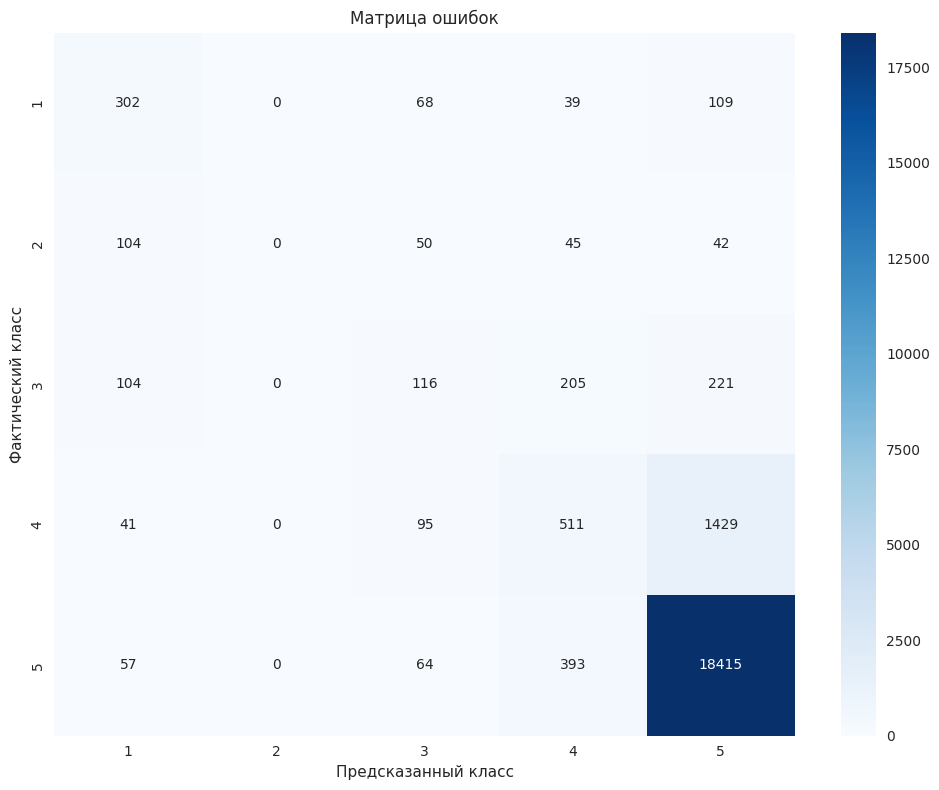

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Accuracy: 0.8632
F1 (weighted): 0.8425
Precision (weighted): 0.8291
Recall (weighted): 0.8632
Spearman correlation: 0.5831


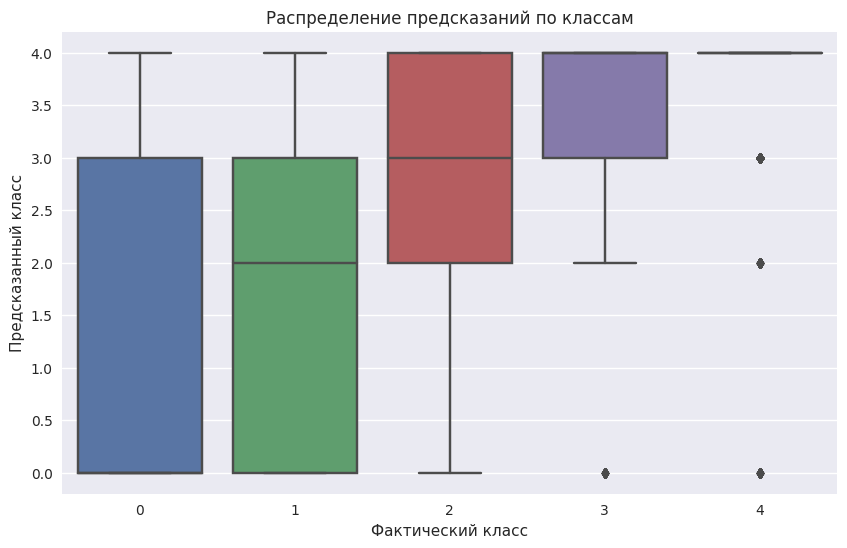

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


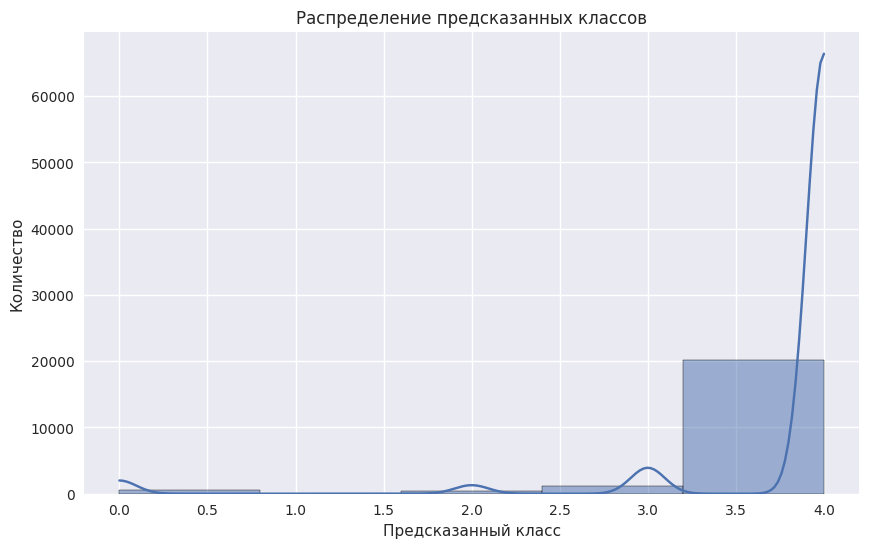

17813

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset, load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import spearmanr
import optuna
from optuna.samplers import TPESampler
import pymorphy2
import re
from functools import partial, lru_cache
import gc

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu.name}, Общая память: {gpu.total_memory / 1e9:.2f} GB")
    
    total_memory, free_memory = torch.cuda.mem_get_info(0)
    print(f"Общая память GPU: {total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {free_memory / 1e9:.2f} GB")

# Проверяем, есть ли уже обработанные данные
if os.path.exists('./processed_data'):
    encoded_train = load_from_disk('./processed_data/train')
    encoded_val = load_from_disk('./processed_data/val')
    print("Загружены предобработанные данные")
else:
    df = pd.read_csv('/kaggle/input/cleaned-kaspi-reviews/cleaned_kaspi_reviews.csv')
    df = df[df['language'] == 'russian']
    df['rating_class'] = df['rating'].astype(int) - 1

    morph = pymorphy2.MorphAnalyzer()
    stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

    @lru_cache(maxsize=None)
    def lemmatize(word):
        return morph.parse(word)[0].normal_form

    def preprocess_text(text):
        if pd.isna(text) or not isinstance(text, str):
            return ''
        text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
        return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

    df['processed_text'] = df['combined_text'].apply(preprocess_text)
    df = df[['processed_text', 'rating_class']].dropna()

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating_class'])

    del df
    gc.collect()

    tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256, use_fast=True)

    def tokenize_function(examples):
        return tokenizer(examples["processed_text"], truncation=True, max_length=256)

    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

    del train_df, val_df
    gc.collect()

    encoded_train = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])
    encoded_val = val_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=['processed_text'])

    encoded_train = encoded_train.rename_column("rating_class", "labels")
    encoded_val = encoded_val.rename_column("rating_class", "labels")

    # Сохраняем закодированные наборы данных на диск
    encoded_train.save_to_disk('./processed_data/train')
    encoded_val.save_to_disk('./processed_data/val')
    print("Данные обработаны и сохранены")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'),
        "spearman": spearmanr(labels, preds)[0]
    }

def objective(trial, train_dataset, val_dataset):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-1, log=True)
    warmup_ratio = trial.suggest_float('warmup_ratio', 0.1, 0.3)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [32, 64])
    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])

    model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

    training_args = TrainingArguments(
        output_dir=f"./results/trial_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        logging_dir=f'./logs/trial_{trial.number}',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="no",
        metric_for_best_model="f1",
        greater_is_better=True,
        load_best_model_at_end=False,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=0,  # Изменено на 0 для избежания создания дополнительных рабочих процессов
        optim="adamw_torch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
    return eval_results["eval_f1"]

study = optuna.create_study(direction="maximize", sampler=TPESampler())
objective_with_dataset = partial(objective, train_dataset=encoded_train, val_dataset=encoded_val)
study.optimize(objective_with_dataset, n_trials=5)  # Уменьшено количество trial до 5

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

del study
gc.collect()
torch.cuda.empty_cache()

best_model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=5).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

best_training_args = TrainingArguments(
    output_dir=f"./results/best_model",  
    num_train_epochs=5,
    per_device_train_batch_size=trial.params['per_device_train_batch_size'], 
    per_device_eval_batch_size=64,
    learning_rate=trial.params['lr'],
    weight_decay=trial.params['weight_decay'],
    warmup_ratio=trial.params['warmup_ratio'],
    logging_dir=f'./logs/best_model',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=trial.params['gradient_accumulation_steps'],
    fp16=True, 
    dataloader_num_workers=0,  # Изменено на 0 для избежания создания дополнительных рабочих процессов
    optim="adamw_torch"
)

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

best_trainer.train()

eval_results = best_trainer.evaluate()
print("Final Evaluation Results:")
print(eval_results)

best_trainer.save_model("./final_model")

print("Training completed. Model saved in ./final_model/ directory")

predictions = best_trainer.predict(encoded_val).predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = encoded_val['labels']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

acc = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
spearman_corr, _ = spearmanr(actual_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=actual_classes, y=predicted_classes)
plt.xlabel('Фактический класс')
plt.ylabel('Предсказанный класс')
plt.title('Распределение предсказаний по классам')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(predicted_classes, bins=5, kde=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество')
plt.title('Распределение предсказанных классов')
plt.show()

del best_model, best_trainer
torch.cuda.empty_cache()
gc.collect()

In [3]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
from datasets import Dataset
import re
import pymorphy2

# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

# Определение стоп-слов (используйте тот же список, что и при обучении)
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

# Функция лемматизации
def lemmatize(word):
    return morph.parse(word)[0].normal_form

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('./final_model')
print("Модель загружена успешно")
print(f"Конфигурация модели: {model.config}")

# Создание пайплайна для классификации
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

def predict_ratings(reviews):
    if len(reviews) == 0:
        return []
    
    processed_reviews = [preprocess_text(review) for review in reviews]
    results = classifier(processed_reviews)
    predicted_ratings = [int(result['label'].split('_')[-1]) + 1 for result in results]
    
    return predicted_ratings

# Функция для ввода отзывов с клавиатуры
def input_reviews():
    reviews = []
    while True:
        review = input("Введите отзыв (или нажмите Enter для завершения): ")
        if review == "":
            break
        reviews.append(review)
    return reviews

# Вызываем функцию для ввода отзывов с клавиатуры
new_reviews = input_reviews()

# Получаем предсказанные оценки для введенных отзывов
predicted_ratings = predict_ratings(new_reviews)

# Выводим результаты предсказаний
if len(predicted_ratings) == 0:
    print("Нет введенных отзывов.")
else:
    for review, rating in zip(new_reviews, predicted_ratings):
        print(f"Отзыв: {review}")
        print(f"Предсказанная оценка: {rating}")
        print()

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

OSError: Incorrect path_or_model_id: './final_model'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
from datasets import Dataset
import re
import pymorphy2

# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

# Определение стоп-слов (используйте тот же список, что и при обучении)
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

# Функция лемматизации
def lemmatize(word):
    return morph.parse(word)[0].normal_form

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('./final_model')

# Создание пайплайна для классификации
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

def predict_ratings(reviews):
    if len(reviews) == 0:
        return []
    
    processed_reviews = [preprocess_text(review) for review in reviews]
    results = classifier(processed_reviews)
    predicted_ratings = [int(result['label'].split('_')[-1]) + 1 for result in results]
    
    return predicted_ratings

# Функция для ввода отзывов с клавиатуры
def input_reviews():
    reviews = []
    while True:
        review = input("Введите отзыв (или нажмите Enter для завершения): ")
        if review == "":
            break
        reviews.append(review)
    return reviews

# Вызываем функцию для ввода отзывов с клавиатуры
new_reviews = input_reviews()

# Получаем предсказанные оценки для введенных отзывов
predicted_ratings = predict_ratings(new_reviews)

# Выводим результаты предсказаний
if len(predicted_ratings) == 0:
    print("Нет введенных отзывов.")
else:
    for review, rating in zip(new_reviews, predicted_ratings):
        print(f"Отзыв: {review}")
        print(f"Предсказанная оценка: {rating}")
        print()

OSError: Incorrect path_or_model_id: './final_model'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
from datasets import Dataset
import re
import pymorphy2

# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

# Определение стоп-слов (используйте тот же список, что и при обучении)
stop_words = set(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так'])

# Функция лемматизации
def lemmatize(word):
    return morph.parse(word)[0].normal_form

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=256, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('./final_model')

# Создание пайплайна для классификации
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = re.sub(r'[^а-яёa-z\s]', '', text.lower().strip())
    return ' '.join(lemmatize(word) for word in text.split() if word not in stop_words)

def predict_ratings(reviews):
    if len(reviews) == 0:
        return []
    
    processed_reviews = [preprocess_text(review) for review in reviews]
    results = classifier(processed_reviews)
    predicted_ratings = [int(result['label'].split('_')[-1]) + 1 for result in results]
    
    return predicted_ratings

# Функция для ввода отзывов с клавиатуры
def input_reviews():
    reviews = []
    while True:
        review = input("Введите отзыв (или нажмите Enter для завершения): ")
        if review == "":
            break
        reviews.append(review)
    return reviews

# Вызываем функцию для ввода отзывов с клавиатуры
new_reviews = input_reviews()

# Получаем предсказанные оценки для введенных отзывов
predicted_ratings = predict_ratings(new_reviews)

# Выводим результаты предсказаний
if len(predicted_ratings) == 0:
    print("Нет введенных отзывов.")
else:
    for review, rating in zip(new_reviews, predicted_ratings):
        print(f"Отзыв: {review}")
        print(f"Предсказанная оценка: {rating}")
        print()

Введите отзыв (или нажмите Enter для завершения):  Нам очень понравился креативный, но одновременно рациональный подход к задаче, умение выслушать клиента и понять потребности целевой аудитории. Отмечаем высокий профессионализм сотрудников компании “KozhinDev”, качество и сжатые сроки выполнения проекта.
Введите отзыв (или нажмите Enter для завершения):   Глубокое погружение в проект, четкое видение и полное понимание ТЗ, а также задач, которые обсуждали на установочной сессии. Разработка заняла 3 месяца, как и планировалось, а дальше пошли докрутки и дополнения. Сотрудничаем с 2019 года и по сей день.
Введите отзыв (или нажмите Enter для завершения):  Мы заказывали у студии KozhinDev разработку сайта и админ панель к нему. Работа сделана качественно, в срок. Менеджер всегда на связи. Правки в ТЗ обсуждались и вносились в проект быстро и без всяких проблем. Баги устраняли тоже очень быстро. Ребята очень контактные, готовы выслушать, понять, предложить варианты и реализовать.
Введите от

Отзыв: Нам очень понравился креативный, но одновременно рациональный подход к задаче, умение выслушать клиента и понять потребности целевой аудитории. Отмечаем высокий профессионализм сотрудников компании “KozhinDev”, качество и сжатые сроки выполнения проекта.
Предсказанная оценка: 5

Отзыв:  Глубокое погружение в проект, четкое видение и полное понимание ТЗ, а также задач, которые обсуждали на установочной сессии. Разработка заняла 3 месяца, как и планировалось, а дальше пошли докрутки и дополнения. Сотрудничаем с 2019 года и по сей день.
Предсказанная оценка: 5

Отзыв: Мы заказывали у студии KozhinDev разработку сайта и админ панель к нему. Работа сделана качественно, в срок. Менеджер всегда на связи. Правки в ТЗ обсуждались и вносились в проект быстро и без всяких проблем. Баги устраняли тоже очень быстро. Ребята очень контактные, готовы выслушать, понять, предложить варианты и реализовать.
Предсказанная оценка: 5

Отзыв: лучший сервис
Предсказанная оценка: 5

Отзыв: средний сервис

In [1]:
from transformers import AutoModelForSequenceClassification

try:
    model = AutoModelForSequenceClassification.from_pretrained('./final_model')
    print("Модель успешно загружена")
    print(f"Количество классов: {model.num_labels}")
    print(f"Название базовой модели: {model.name_or_path}")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")

Ошибка при загрузке модели: Incorrect path_or_model_id: './final_model'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


In [3]:
def find_model_dir(start_path='.'):
    for root, dirs, files in os.walk(start_path):
        if 'config.json' in files and 'pytorch_model.bin' in files:
            return root
    return None

model_dir = find_model_dir()
if model_dir:
    print(f"Директория с моделью найдена: {model_dir}")
else:
    print("Директория с моделью не найдена")

Директория с моделью не найдена


In [2]:
import os

if os.path.exists('./final_model'):
    print("Директория ./final_model существует")
    print("Содержимое директории:")
    print(os.listdir('./final_model'))
else:
    print("Директория ./final_model не существует")

Директория ./final_model не существует


In [4]:
# Функция для предсказания оценок для новых отзывов
def predict_ratings(reviews):
    if len(reviews) == 0:
        return []
    
    new_data = pd.DataFrame({'combined_text': reviews})
    new_data['processed_text'] = new_data['combined_text'].apply(preprocess_text)
    new_dataset = Dataset.from_pandas(new_data)
    
    tokenized_new_data = new_dataset.map(tokenize_function, batched=True, remove_columns=['combined_text'])
    
    predictions = best_trainer.predict(tokenized_new_data).predictions
    if len(predictions.shape) == 1:
        predicted_ratings = np.argmax(predictions.reshape(1, -1), axis=1) + 1
    else:
        predicted_ratings = np.argmax(predictions, axis=1) + 1
        
    return predicted_ratings.tolist()

# Функция для ввода отзывов с клавиатуры
def input_reviews():
    reviews = []
    while True:
        review = input("Введите отзыв (или нажмите Enter для завершения): ")
        if review == "":
            break
        reviews.append(review)
    return reviews

# Вызываем функцию для ввода отзывов с клавиатуры
new_reviews = input_reviews()

# Получаем предсказанные оценки для введенных отзывов
predicted_ratings = predict_ratings(new_reviews)

# Выводим результаты предсказаний
if len(predicted_ratings) == 0:
    print("Нет введенных отзывов.")
else:
    for review, rating in zip(new_reviews, predicted_ratings):
        print(f"Отзыв: {review}")
        print(f"Предсказанная оценка: {rating}")
        print()

Введите отзыв (или нажмите Enter для завершения):  Нам очень понравился креативный, но одновременно рациональный подход к задаче, умение выслушать клиента и понять потребности целевой аудитории. Отмечаем высокий профессионализм сотрудников компании “KozhinDev”, качество и сжатые сроки выполнения проекта.
Введите отзыв (или нажмите Enter для завершения):  Глубокое погружение в проект, четкое видение и полное понимание ТЗ, а также задач, которые обсуждали на установочной сессии. Разработка заняла 3 месяца, как и планировалось, а дальше пошли докрутки и дополнения. Сотрудничаем с 2019 года и по сей день.
Введите отзыв (или нажмите Enter для завершения):  Мы заказывали у студии KozhinDev разработку сайта и админ панель к нему. Работа сделана качественно, в срок. Менеджер всегда на связи. Правки в ТЗ обсуждались и вносились в проект быстро и без всяких проблем. Баги устраняли тоже очень быстро. Ребята очень контактные, готовы выслушать, понять, предложить варианты и реализовать.
Введите отз

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

NameError: name 'best_trainer' is not defined

In [1]:
import gc
gc.collect()

11

In [ ]:


# Функция для предсказания оценок для новых отзывов
def predict_ratings(reviews):
    if len(reviews) == 0:
        return []
    
    # Создаем DataFrame из новых отзывов
    new_data = pd.DataFrame({'combined_text': reviews})
    new_data['processed_text'] = new_data['combined_text'].apply(preprocess_text)
    new_dataset = Dataset.from_pandas(new_data)
    
    # Токенизируем новые отзывы
    tokenized_new_data = new_dataset.map(tokenize_function, batched=True, remove_columns=['combined_text'])
    
    # Получаем предсказания модели для новых отзывов
    predictions = trainer.predict(tokenized_new_data).predictions
    
    if len(predictions.shape) == 1:
        predicted_ratings = np.argmax(predictions.reshape(1, -1), axis=1) + 1
    else:
        predicted_ratings = np.argmax(predictions, axis=1) + 1
    
    return predicted_ratings.tolist()

# Функция для ввода отзывов с клавиатуры
def input_reviews():
    reviews = []
    while True:
        review = input("Введите отзыв (или нажмите Enter для завершения): ")
        if review == "":
            break
        reviews.append(review)
    return reviews

# Вызываем функцию для ввода отзывов с клавиатуры
new_reviews = input_reviews()

# Получаем предсказанные оценки для введенных отзывов
predicted_ratings = predict_ratings(new_reviews)

# Выводим результаты предсказаний
if len(predicted_ratings) == 0:
    print("Нет введенных отзывов.")
else:
    for review, rating in zip(new_reviews, predicted_ratings):
        print(f"Отзыв: {review}")
        print(f"Предсказанная оценка: {rating}")
        print()

Нам очень понравился креативный, но одновременно рациональный подход к задаче, умение выслушать клиента и понять потребности целевой аудитории. Отмечаем высокий профессионализм сотрудников компании “KozhinDev”, качество и сжатые сроки выполнения проекта.



Глубокое погружение в проект, четкое видение и полное понимание ТЗ, а также задач, которые обсуждали на установочной сессии. Разработка заняла 3 месяца, как и планировалось, а дальше пошли докрутки и дополнения. Сотрудничаем с 2019 года и по сей день.



Мы заказывали у студии KozhinDev разработку сайта и админ панель к нему. Работа сделана качественно, в срок. Менеджер всегда на связи. Правки в ТЗ обсуждались и вносились в проект быстро и без всяких проблем. Баги устраняли тоже очень быстро. Ребята очень контактные, готовы выслушать, понять, предложить варианты и реализовать.



Команда KozhinDev реализовала интерфейс для управления настройками нейронной сети, которая осуществляла расчет для решения бизнес задачи заказчика. Ребята очень умные, быстро поняли суть задачи и проактивно сработали, предложив лучшие способы решения. Проект был сдан точно в срок. Разработка существенно влияет на максимизацию нашей прибыли.



Работали с командой KozhinDev по проекту Инвойс‑бокс, ощущение от работы исключительно положительные. Выбрал KozhinDev как партнёров, потому что знаю подход Владимира к подбору людей, и что у него работают крутые специалисты. По итогу выбор себя оправдал, разработчик, который с нами сотрудничает, крутой специалист!



Разрабатывали ПО, связанное с получением данных по api со стороннего сервиса. Ребята с самого начала полностью погрузились в проект, помогли в написании ТЗ. Чувствуется высокий уровень организованности команды. Будем и дальше плотно работать, улучшать свой продукт, наполнять новым функционалом.



Положительный опыт работы с KozhinDev: сильная команда разработки, всегда на связи. На встречах и обсуждениях проекта тимлид и менеджер проекта задавали правильные вопросы. Были готовы изучать что‑то дополнительно. Будем рады поработать ещё.



Команда KozhinDev разработала АИС для оптимизации бизнес‑процессов нашей приемной комиссии, осуществляла техническую поддержку операторов на протяжении всей приемной кампании. Проявили себя как профессионалы своего дела, готовые не только прийти на помощь клиенту, но и, разобравшись в тонкостях процесса и организационной структуры, выносить свои предложения по их оптимизации; Это отзывы, которые нужно оценить исходя из обученной модели

In [ ]:
print("hello")

In [ ]:
print("hi")

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import torch
from torch import nn
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

df = pd.read_csv('cleaned_kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df['rating_10'] = df['rating'] * 2

def preprocess_text(text):
    return text.lower().strip() if isinstance(text, str) else ''

df['processed_text'] = df['combined_text'].apply(preprocess_text)
df = df.dropna(subset=['processed_text', 'rating_10'])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text', 'combined_text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['processed_text', 'combined_text'])

tokenized_train = tokenized_train.rename_column("rating_10", "labels")
tokenized_test = tokenized_test.rename_column("rating_10", "labels")

class RegressionModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.regressor(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(logits.squeeze(), labels)
        
        return loss, logits.squeeze()

model = RegressionModel('cointegrated/rubert-tiny')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    spearman_corr, _ = spearmanr(labels, predictions)
    accuracy_1 = np.mean(np.abs(predictions - labels) <= 1)
    
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "spearman": spearman_corr,
        "accuracy_1": accuracy_1
    }

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_rmse",
    greater_is_better=False,
    gradient_accumulation_steps=4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Результаты оценки:", eval_results)

trainer.save_model("./final_model")

predictions = trainer.predict(tokenized_test).predictions
actual = tokenized_test['labels']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual, y=predictions, alpha=0.5)
plt.plot([1, 10], [1, 10], 'r--')
plt.xlabel('Фактические оценки')
plt.ylabel('Предсказанные оценки')
plt.title('Фактические vs Предсказанные оценки')
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(actual, shade=True, label='Фактические')
sns.kdeplot(predictions, shade=True, label='Предсказанные')
plt.xlabel('Оценка')
plt.ylabel('Плотность')
plt.title('Распределение фактических и предсказанных оценок')
plt.legend()
plt.show()

print(f"RMSE: {eval_results['eval_rmse']:.4f}")
print(f"MAE: {eval_results['eval_mae']:.4f}")
print(f"R2: {eval_results['eval_r2']:.4f}")
print(f"Spearman correlation: {eval_results['eval_spearman']:.4f}")
print(f"Accuracy within 1 point: {eval_results['eval_accuracy_1']:.4f}")